# Implementation of Variational Autoencoder in MXNet/Gluon

This is the implementation using the new Gluon API, i.e. gluon.HybridBlock and autograd.

Instead of using fully connected layers we used CNN in this implementation to parameterize recognition and generation network.

Ref paper: Kingma, Diederik P., and Max Welling. ["Auto-encoding variational bayes."](https://arxiv.org/abs/1312.6114) arXiv preprint arXiv:1312.6114 (2013).

In [1]:
import time
import numpy as np
import mxnet as mx
from tqdm import tqdm, tqdm_notebook
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import matplotlib.pyplot as plt
%matplotlib inline
data_ctx = mx.cpu()
model_ctx = mx.gpu(0)
mx.random.seed(1)
output_fig = False

# Load MNIST

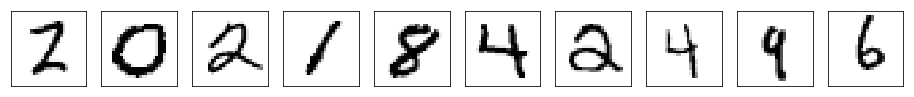

In [2]:
mnist = mx.test_utils.get_mnist()
#print(mnist['train_data'][0].shape)
#plt.imshow(mnist['train_data'][0][0],cmap='Greys')

n_samples = 10
idx = np.random.choice(len(mnist['train_data']), n_samples)
_, axarr = plt.subplots(1, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[i].imshow(mnist['train_data'][j][0], cmap='Greys')
    #axarr[i].axis('off')
    axarr[i].get_xaxis().set_ticks([])
    axarr[i].get_yaxis().set_ticks([])
plt.show()

In [3]:
#train_data = np.reshape(mnist['train_data'],(-1,28*28))
#test_data = np.reshape(mnist['test_data'],(-1,28*28))
train_data = mnist['train_data']
test_data = mnist['test_data']

In [4]:
mnist['test_data'].shape

(10000, 1, 28, 28)

In [5]:
batch_size = 100
n_batches = train_data.shape[0]/batch_size
train_iter = mx.io.NDArrayIter(data={'data': train_data}, label={'label': mnist['train_label']}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': test_data}, label={'label': mnist['test_label']}, batch_size = batch_size)
#train_iter = mx.io.NDArrayIter(data={'data': train_data}, batch_size = batch_size)
#test_iter = mx.io.NDArrayIter(data={'data': test_data}, batch_size = batch_size)

# Define model

In [6]:
class Reshape(gluon.HybridBlock):
    def __init__(self, target_shape, **kwargs):
        super().__init__(**kwargs)
        self.target_shape = target_shape

    def hybrid_forward(self, F, x):
        #print(x.shape)
        return x.reshape((0, *self.target_shape)) # setting the first axis to 0 to copy over the original shape, i.e. batch_size

    def __repr__(self):
        return self.__class__.__name__


class VAE(gluon.HybridBlock):
    def __init__(self, n_ch=np.array([4,8,16])*4, ks=[4,4,4], stride=[2,2,2], pad=[1,0,0], n_latent=2, n_layers=1, batch_size=100, act_type='tanh', **kwargs):
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.output = None
        self.mu = None
        # note to self: requring batch_size in model definition is sad, not sure how to deal with this otherwise though
        super().__init__(**kwargs)

        img_size =[28]
        with self.name_scope():
            self.encoder = nn.HybridSequential(prefix='encoder')
            for i in range(n_layers):
                self.encoder.add(nn.Conv2D(channels=n_ch[i], kernel_size=ks[i], strides=stride[i], padding=pad[i], activation=act_type))
                old_size = img_size[-1] + 2*pad[i]
                new_size = (old_size - (ks[i] - stride[i]))// stride[i]
                #print(new_size)
                img_size.append(new_size)
                if i < n_layers-1:
                    self.encoder.add(nn.BatchNorm())

            self.encoder.add(nn.Flatten())
            #self.encoder.add(nn.Dense(100, activation=act_type)) 
            self.encoder.add(nn.Dense(n_latent*2, activation=None)) 
            
            
            self.decoder = nn.HybridSequential(prefix='decoder')
            #self.decoder.add(nn.Dense(100, activation=act_type)) 
            self.decoder.add(nn.Dense(img_size[-1]*img_size[-1]*n_ch[-1], activation=act_type))
            self.decoder.add(Reshape((n_ch[-1], img_size[-1], img_size[-1])))
            for i in range(n_layers-1, -1, -1):

                if i == 0:
                    act_type = 'sigmoid'
                    ch = 1
                else:
                    ch = n_ch[i-1]
                    
                self.decoder.add(nn.Conv2DTranspose(channels=ch, kernel_size=ks[i], strides=stride[i], padding=pad[i], activation=act_type))
                if i >0:
                    self.encoder.add(nn.BatchNorm())

                
    def hybrid_forward(self, F, x):
        h = self.encoder(x)
        #print(h)
        mu_lv = F.split(h, axis=1, num_outputs=2)
        mu = mu_lv[0]
        lv = mu_lv[1]
        self.mu = mu
        #eps = F.random_normal(loc=0, scale=1, shape=mu.shape, ctx=model_ctx) 
        # this would work fine only for nd (i.e. non-hybridized block)
        eps = F.random_normal(loc=0, scale=1, shape=(self.batch_size, self.n_latent), ctx=model_ctx)
        z = mu + F.exp(0.5*lv)*eps
        y = self.decoder(z)

        y = y.reshape((0,-1))
        x = x.reshape((0,-1))
        self.output = y
        
        KL = 0.5*F.sum(1+lv-mu*mu-F.exp(lv),axis=1)
        logloss = F.sum(x*F.log(y+self.soft_zero)+ (1-x)*F.log(1-y+self.soft_zero), axis=1)
        loss = -logloss-KL
        
        return loss

In [7]:
n_latent=2
n_layers=3 # num of dense layers in encoder and decoder respectively
model_prefix = 'vaecnn_gluon.params'

net = VAE(n_latent=n_latent, n_layers=n_layers, batch_size=batch_size)

In [8]:
x = nd.random.normal(shape=(100,1,28,28), ctx=model_ctx)
net.collect_params().initialize(mx.init.Xavier(), ctx=model_ctx)

In [9]:
#net.encoder(x).shape
net.decoder(net.encoder(x)).shape

(100, 1, 28, 28)

In [10]:
net = VAE(n_latent=n_latent, n_layers=n_layers, batch_size=batch_size)
net.collect_params().initialize(mx.init.Xavier(), ctx=model_ctx)
net(x)


[ 543.76800537  544.45910645  543.48931885  544.60949707  544.09594727
  544.52929688  543.40856934  544.26818848  543.65185547  543.61352539
  543.2555542   543.237854    543.74609375  543.65087891  543.77807617
  543.25488281  543.28271484  543.8494873   543.46533203  543.71112061
  544.01745605  543.79101562  543.37524414  543.33905029  543.90692139
  543.84997559  544.97613525  542.49078369  543.3614502   543.66540527
  543.62792969  543.37139893  543.68811035  543.53918457  544.09527588
  542.62438965  543.78875732  542.97729492  543.83056641  543.25494385
  543.76794434  543.82885742  543.13708496  543.15930176  543.68554688
  543.72137451  544.15655518  543.28167725  542.93084717  544.00415039
  543.48217773  544.12481689  543.82147217  544.48144531  543.59613037
  543.55108643  543.65881348  544.2109375   543.76806641  543.19903564
  543.76184082  543.80914307  543.19018555  543.69451904  542.57800293
  543.34521484  542.74163818  543.81988525  542.98175049  543.8838501
  543.

# Model training

In [11]:
net = VAE(n_latent=n_latent, n_layers=n_layers, batch_size=batch_size)
net.collect_params().initialize(mx.init.Xavier(), ctx=model_ctx)
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .001})

In [12]:
n_epoch = 50
print_period = n_epoch // 10
start = time.time()

training_loss = []
validation_loss = []
for epoch in tqdm_notebook(range(n_epoch), desc='epochs'):
    epoch_loss = 0
    epoch_val_loss = 0
    
    train_iter.reset()
    test_iter.reset()
    
    n_batch_train = 0
    for batch in train_iter:
        n_batch_train +=1
        data = batch.data[0].as_in_context(model_ctx)
        with autograd.record():
            loss = net(data)
        loss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(loss).asscalar()
    
    n_batch_val = 0
    for batch in test_iter:
        n_batch_val +=1
        data = batch.data[0].as_in_context(model_ctx)
        loss = net(data)
        epoch_val_loss += nd.mean(loss).asscalar()
    
    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val
    
    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)
    
    if epoch % max(print_period,1) == 0:
        tqdm.write('Epoch %d, Training loss %s, Validation loss %s' % (epoch, epoch_loss, epoch_val_loss))
        
end = time.time()
print('Time elapsed: {:.2f}s'.format(end - start))

HBox(children=(IntProgress(value=0, description='epochs: ', max=50), HTML(value='')))

Epoch 0, Training loss 226.182277298, Validation loss 188.132845917
Epoch 5, Training loss 166.907464727, Validation loss 164.42768631
Epoch 10, Training loss 158.874235408, Validation loss 156.513752441
Epoch 15, Training loss 155.654563497, Validation loss 153.682533722
Epoch 20, Training loss 153.967922974, Validation loss 151.862315521
Epoch 25, Training loss 152.88735054, Validation loss 151.411156464
Epoch 30, Training loss 152.006352081, Validation loss 150.80643219
Epoch 35, Training loss 151.271434708, Validation loss 150.228639832
Epoch 40, Training loss 150.737377396, Validation loss 150.039590683
Epoch 45, Training loss 150.338546092, Validation loss 150.17649353

Time elapsed: 252.32s


In [13]:
net.save_params(model_prefix)

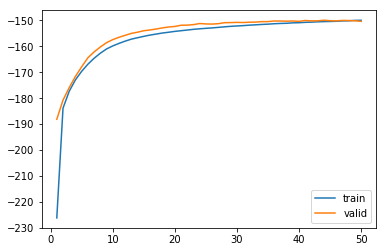

In [14]:
batch_x = np.linspace(1, n_epoch, len(training_loss))
plt.plot(batch_x, -1*np.array(training_loss))
plt.plot(batch_x, -1*np.array(validation_loss))
plt.legend(['train', 'valid'])

# Load model

In [15]:
net2 = VAE(n_latent=n_latent, n_layers=n_layers, batch_size=batch_size)
net2.load_params(model_prefix, ctx=model_ctx)

# Visualizing reconstruction quality

In [16]:
test_iter.reset()
test_batch = test_iter.next()
net2(test_batch.data[0].as_in_context(model_ctx))
result = net2.output.asnumpy()
original = test_batch.data[0].asnumpy()

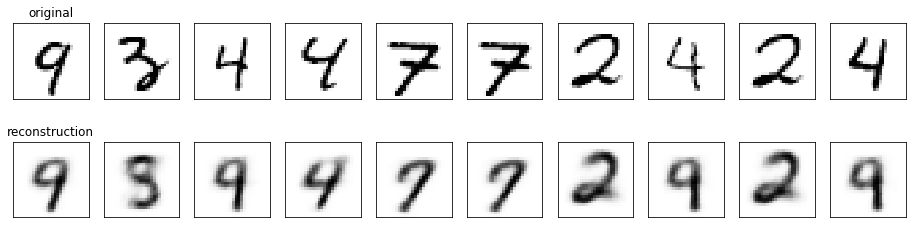

In [17]:
n_samples = 10
idx = np.random.choice(batch_size, n_samples)
_, axarr = plt.subplots(2, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[0,i].imshow(original[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[0,i].set_title('original')
    #axarr[0,i].axis('off')
    axarr[0,i].get_xaxis().set_ticks([])
    axarr[0,i].get_yaxis().set_ticks([])

    axarr[1,i].imshow(result[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[1,i].set_title('reconstruction')
    #axarr[1,i].axis('off')
    axarr[1,i].get_xaxis().set_ticks([])
    axarr[1,i].get_yaxis().set_ticks([])
plt.show()

# Visualizing latent space (when it is 2D)

In [18]:
n_batches = 10
counter = 0
results = []
labels = []
for batch in test_iter:
    net2(batch.data[0].as_in_context(model_ctx))
    results.append(net2.mu.asnumpy())
    labels.append(batch.label[0].asnumpy())
    counter +=1
    if counter >= n_batches:
        break

In [19]:
result= np.vstack(results)
labels = np.hstack(labels)

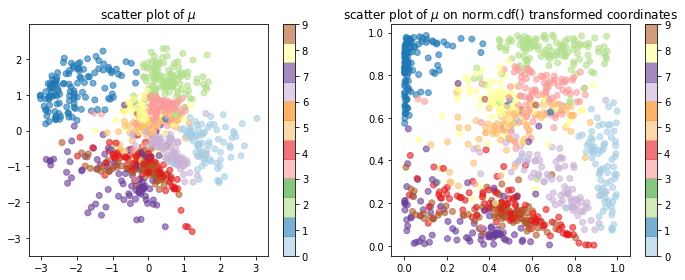

In [20]:
if result.shape[1]==2:
    from scipy.special import ndtri
    from scipy.stats import norm

    fig, axarr = plt.subplots(1,2, figsize=(10,4))
    im=axarr[0].scatter(result[:, 0], result[:, 1], c=labels, alpha=0.6, cmap='Paired')
    axarr[0].set_title('scatter plot of $\mu$')
    axarr[0].axis('equal')
    fig.colorbar(im, ax=axarr[0])

    im=axarr[1].scatter(norm.cdf(result[:, 0]), norm.cdf(result[:, 1]), c=labels, alpha=0.6, cmap='Paired')
    axarr[1].set_title('scatter plot of $\mu$ on norm.cdf() transformed coordinates')
    axarr[1].axis('equal')
    fig.colorbar(im, ax=axarr[1])
    plt.tight_layout()
    if output_fig:
        plt.savefig('2d_latent_space_for_test_samples.png')

# Sample latent space and generate images

## Random sampling

In [21]:
n_samples = 10
zsamples = nd.array(np.random.randn(n_samples*n_samples, n_latent))

In [22]:
images = net2.decoder(zsamples.as_in_context(model_ctx)).asnumpy()

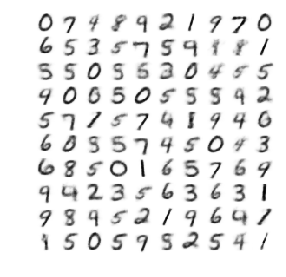

In [23]:
canvas = np.empty((28*n_samples, 28*n_samples))
for i, img in enumerate(images):
    x = i // n_samples
    y = i % n_samples
    canvas[(n_samples-y-1)*28:(n_samples-y)*28, x*28:(x+1)*28] = img.reshape(28, 28)
plt.figure(figsize=(4, 4))        
plt.imshow(canvas, origin="upper", cmap="Greys")
plt.axis('off')
plt.tight_layout()
if output_fig:
    plt.savefig('generated_samples_with_{}D_latent_space.png'.format(n_latent))

## Grid scan 2D latent space

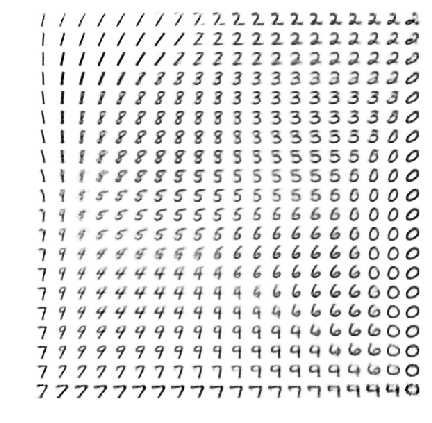

In [24]:
if n_latent==2: 
    n_pts = 20

    idx = np.arange(0, n_pts)

    x = np.linspace(norm.cdf(-3), norm.cdf(3),n_pts)
    x = ndtri(x)

    x_grid = np.array(np.meshgrid(*[i for i in np.matlib.repmat(x,n_latent,1)]))
    id_grid = np.array(np.meshgrid(*[i for i in np.matlib.repmat(idx,n_latent,1)]))

    zsamples = nd.array(x_grid.reshape((n_latent, -1)).transpose())
    zsamples_id = id_grid.reshape((n_latent, -1)).transpose()

    images = net2.decoder(zsamples.as_in_context(model_ctx)).asnumpy()

    #plot
    canvas = np.empty((28*n_pts, 28*n_pts))
    for i, img in enumerate(images):
        #plt.imshow(img.reshape(28,28))
        x, y = zsamples_id[i]
        canvas[(n_pts-y-1)*28:(n_pts-y)*28, x*28:(x+1)*28] = img.reshape(28, 28)
    plt.figure(figsize=(6, 6))        
    plt.imshow(canvas, origin="upper", cmap="Greys")
    plt.axis('off')
    plt.tight_layout()
    if output_fig:
        plt.savefig('2d_latent_space_scan_for_generation.png')